In [1]:
import torch
from torch import nn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from typing import List, Tuple, Dict, Callable

import time

In [2]:
from IPython.display import display as d

In [3]:
from omegaconf import OmegaConf

## Some solutions of PDE (partial differential equations)

In [4]:
N = 10_000

x: torch.Tensor = torch.empty(size=(N, ))
x.uniform_(0, 1)


y: torch.Tensor = torch.empty(size=(N, ))
y.uniform_(0, 1)
# t: torch.Tensor = torch.empty(size=(batch_size, 1))
# t.uniform_(0, 10)

u: List # u = u(x, t)

In [5]:
u = torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

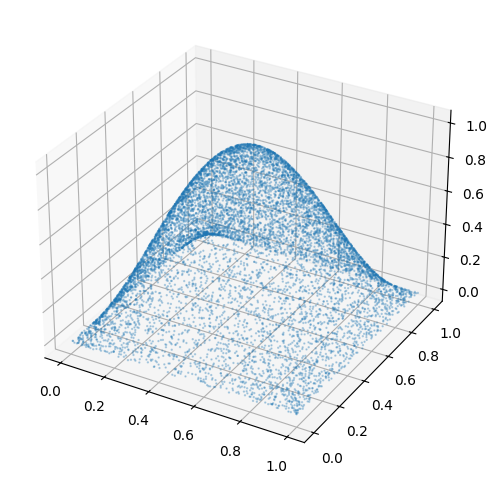

In [6]:
ax = plt.figure(figsize=(6, 6)).add_subplot(projection="3d")

ax.scatter(x, y, u, s=0.5, alpha=0.3)

plt.show()

In [7]:
plt.close("all")

## PINN for solving PDE

In [85]:
from src.data.components.dataset import SpatialXTemporalDomain
from src.data.components.collate import BaseCollator, ModelInput, SingleForwardState, Coords, ModelBatch

In [92]:
class SpatialXTemporalDomain2D(torch.utils.data.Dataset):
    def __init__(
            self, 
            n_samples: int = 10_000, 
            seq_len: int = 128,
            xmin: float = 0.0, 
            xmax: float = 1.0, 
            tmin: float = 0.0, 
            tmax: float = 1.0,
            noise: float = 0.0
        ) -> None:

        self.data_size = n_samples

        self.nrof_bins = self.data_size // seq_len

        _X: torch.Tensor = torch.empty(size=(n_samples, 1))
        _X.uniform_(xmin, xmax)

        _X = torch.sort(_X.ravel()).values
        
        self.X = torch.stack(
            [
                _X[bin * seq_len:bin * seq_len + seq_len][torch.randperm(seq_len)] for bin in range(self.nrof_bins)
            ]
        )[torch.randperm(self.nrof_bins)]

        self.X += noise * torch.randn(size=self.X.size())


        _T: torch.Tensor = torch.empty(size=(n_samples, 1))
        _T.uniform_(tmin, tmax)

        _T = torch.sort(_T.ravel()).values
        
        self.T = torch.stack(
            [
                _T[bin * seq_len:bin * seq_len + seq_len][torch.randperm(seq_len)] for bin in range(self.nrof_bins)
            ]
        )[torch.randperm(self.nrof_bins)]

        self.T += noise * torch.randn(size=self.T.size())


    def __getitem__(self, idx: int):
        return {
            "coords": {
                "x": self.X[idx]
            },
            "time": self.T[idx]
        }

    def __len__(self):
        return self.nrof_bins

In [93]:
dataset = SpatialXTemporalDomain2D(n_samples=100_000, seq_len=128, xmin=-10, xmax=10, tmin=0, tmax=20)

In [94]:
train, valid = torch.utils.data.random_split(
    dataset, [0.9, 0.1]
)

In [106]:
BATCH_SIZE = 64

In [125]:
class BaseCollator:
    def __init__(self, with_coords: bool = True, with_time: bool = True):
        self.with_coords = with_coords
        self.with_time = with_time

    def __call__(self, batch: List[Dict]) -> ModelBatch:
        if self.with_coords:
            coords_keys = ["x", "y", "z"]

            coords = dict().fromkeys(coords_keys)

            for key in batch[0]["coords"].keys():
                coords[key] = torch.stack([item["coords"][key] for item in batch], dim=0).unsqueeze(dim=-1)

                coords[key].requires_grad_(True)
        else:
            coords = None

        if self.with_time:
            time = torch.stack([item["time"] for item in batch], dim=0).unsqueeze(dim=-1)

            time.requires_grad_(True)
        else:
            time = None

        return ModelBatch(
            coords=Coords(**coords), 
            time=time
        )

In [126]:
train_loader = torch.utils.data.DataLoader(
    dataset=train, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    collate_fn=BaseCollator()
)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    collate_fn=BaseCollator()
)

In [127]:
sample = next(iter(train_loader))

In [129]:
d(sample.coords.x.size())

torch.Size([64, 128, 1])

In [130]:
from src.models.pde_lit_model_xt import PDELitModule
from src.models.components.pde_nn import PDESimpleNN
from src.models.components.linear_blocks.linear_down_up_block import LinearDownUpBlock

In [131]:
class PDEBurgerCondition(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs: ModelInput) -> torch.Tensor:
        return torch.zeros(size=inputs.time.size())


class InitialConditions(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, coords: Coords) -> torch.Tensor:
        return torch.exp(-torch.square(coords.x) / 2)
        # return torch.zeros(coords.x.size())


class BoundaryXYZConditions(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs: ModelInput) -> torch.Tensor:
        return torch.zeros(size=inputs.time.size())

In [132]:
class MainEncoderLayer(nn.Module):
    def __init__(
            self,
            embedding_sequence_dim: int = 8,
            embedding_features_dim: int = 0,
            dropout_inputs: float = 0.3,
            num_coords: bool = False,
            with_time: bool = False
        ) -> None:
        super(MainEncoderLayer, self).__init__()

        self.dropout = nn.Dropout(p=dropout_inputs)

        self.branched_linear_block_xyz = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(1, embedding_sequence_dim),
                    nn.Tanh()
                ) for _ in range(num_coords)
            ]
        )

        self.linear_block_t = nn.Sequential(
            nn.Linear(1, embedding_sequence_dim),
            nn.Tanh()
        ) if with_time else None

        if embedding_features_dim > 0:
            in_features = num_coords + 1 if with_time else num_coords

            self.out_linear_block = nn.Linear(
                in_features, embedding_features_dim
            )
        else:
            self.out_linear_block = nn.Identity()


    def forward(self, inputs: ModelInput) -> SingleForwardState:

        coords = [coord for coord in inputs.coords if coord is not None]

        coords_emb = torch.concatenate(
            [
                head(coord) for coord, head in zip(coords, self.branched_linear_block_xyz)
            ], dim=1
        )

        time_emb = self.linear_block_t(inputs.time)

        # emb = torch.stack([coords_emb, time_emb], dim=-1) # (batch_size, emb_dim, num_coords + 1)
        emb = torch.concatenate([coords_emb, time_emb], dim=-1)

        x = self.dropout(emb)
        # x = self.out_linear_block(x)

        return SingleForwardState(
            sequences=x
        )

In [133]:
EMB_DIM = 8

In [134]:
a = MainEncoderLayer(
    embedding_sequence_dim=EMB_DIM, 
    dropout_inputs=0.3, 
    num_coords=1, 
    with_time=True
)

In [135]:
d(a(sample).sequences.size())

torch.Size([64, 128, 16])

In [39]:
emb_dim = 8

model = PDESimpleNN(
    layers=[
        MainEncoderLayer(
            embedding_sequence_dim=emb_dim, 
            embedding_features_dim=1, 
            dropout_inputs=0.3, 
            num_coords=1, 
            with_time=True
        ),
        LinearDownUpBlock(
            in_features=emb_dim * 2,
            out_features=1,
            down=True,
            num_layers=2,
            dropout_rate=0.0,
            activation_type="tanh",
            use_batch_norm=False
        )
    ]
)

In [40]:
model.layers

Sequential(
  (0): MainEncoderLayer(
    (dropout): Dropout(p=0.3, inplace=False)
    (branched_linear_block_xyz): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=1, out_features=16, bias=True)
        (1): Tanh()
      )
    )
    (linear_block_t): Sequential(
      (0): Linear(in_features=1, out_features=16, bias=True)
      (1): Tanh()
    )
    (out_linear_block): Linear(in_features=2, out_features=1, bias=True)
  )
  (1): LinearDownUpBlock(
    (dropout): Dropout(p=0.0, inplace=False)
    (linear_block): Sequential(
      (0): Sequential(
        (0): Linear(in_features=32, out_features=16, bias=True)
        (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (2): Tanh()
      )
      (1): Sequential(
        (0): Linear(in_features=16, out_features=8, bias=True)
        (1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (2): Tanh()
      )
    )
    (out_block): Linear(in_features=8, out_features=1, bias=True)
    (cls_layers): Sequ

In [41]:
lit_module = PDELitModule(
    net=model,
    train_batch_size=BATCH_SIZE,
    val_batch_size=BATCH_SIZE,
    conditional_loss="val/loss",
    condition_names=["pdec", "ic", "bc_lower", "bc_upper"],
    num_coords=1,
    pdec=PDEBurgerCondition(),
    ic=[InitialConditions()],
    bc_limits=[-3.0, 3.0],
    bc=[BoundaryXYZConditions(), BoundaryXYZConditions()],
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
)

/home/danil/projects/torch_template/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
/home/danil/projects/torch_template/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'pdec' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['pdec'])`.


In [42]:
print(lit_module.model_step(sample))

(tensor(1.7912, grad_fn=<AddBackward0>), {'pdec': tensor(0.0607), 'ic': tensor(0.7388), 'bc_lower': tensor(0.5561), 'bc_upper': tensor(0.4357)}, ModelOutput(representations=tensor([[ 1.3556,  0.0000,  0.0000,  ..., -0.0000,  0.0000, -1.3581],
        [ 1.3481,  1.2334,  1.2127,  ..., -1.1221,  0.0000,  0.0000],
        [ 0.0303, -0.9100, -0.0000,  ..., -1.3719,  1.1559, -0.0000],
        ...,
        [-0.7954, -0.0000, -0.0000,  ..., -1.4281,  1.3332, -1.4195],
        [ 0.6782, -0.2411, -0.0000,  ..., -0.0000,  0.0000, -1.3735],
        [-0.0000, -1.0863, -1.0947,  ..., -1.4005,  0.0000, -1.0180]],
       grad_fn=<MulBackward0>), logits=tensor([[-0.4503],
        [-0.3462],
        [-0.9643],
        [-0.1385],
        [-0.3229],
        [-0.9093],
        [-0.8206],
        [-0.9881],
        [-0.5753],
        [-0.9712],
        [-0.1872],
        [ 0.0465],
        [-0.9795],
        [-0.6621],
        [-0.7474],
        [ 0.6161],
        [-0.8696],
        [-0.6438],
        [-0.

In [43]:
d(lit_module)

PDELitModule(
  (net): PDESimpleNN(
    (layers): Sequential(
      (0): MainEncoderLayer(
        (dropout): Dropout(p=0.3, inplace=False)
        (branched_linear_block_xyz): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): Tanh()
          )
        )
        (linear_block_t): Sequential(
          (0): Linear(in_features=1, out_features=16, bias=True)
          (1): Tanh()
        )
        (out_linear_block): Linear(in_features=2, out_features=1, bias=True)
      )
      (1): LinearDownUpBlock(
        (dropout): Dropout(p=0.0, inplace=False)
        (linear_block): Sequential(
          (0): Sequential(
            (0): Linear(in_features=32, out_features=16, bias=True)
            (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
            (2): Tanh()
          )
          (1): Sequential(
            (0): Linear(in_features=16, out_features=8, bias=True)
            (1): LayerNorm((8,), eps=1e-0

In [44]:
d(dict(model.named_parameters()))

{'layers.0.branched_linear_block_xyz.0.0.weight': Parameter containing:
 tensor([[ 0.5918],
         [ 0.6967],
         [ 0.6845],
         [ 0.6954],
         [ 0.6681],
         [-0.5791],
         [ 0.0053],
         [ 0.3269],
         [ 0.4304],
         [ 0.8340],
         [ 0.2474],
         [-0.1195],
         [ 0.5653],
         [ 0.3647],
         [ 0.8884],
         [ 0.8415]], requires_grad=True),
 'layers.0.branched_linear_block_xyz.0.0.bias': Parameter containing:
 tensor([ 0.2585, -0.4737, -0.4970,  0.1973, -0.8888,  0.4463,  0.9975,  0.1125,
          0.4164, -0.2811, -0.9206,  0.4627, -0.1488,  0.5116, -0.8850,  0.3967],
        requires_grad=True),
 'layers.0.linear_block_t.0.weight': Parameter containing:
 tensor([[-0.3296],
         [ 0.4107],
         [ 0.3477],
         [ 0.4831],
         [ 0.3153],
         [-0.4682],
         [-0.1742],
         [-0.9130],
         [ 0.2015],
         [ 0.4486],
         [ 0.4619],
         [-0.0185],
         [ 0.9418],
     

In [45]:
class Trainer:
    def __init__(
            self, 
            net: nn.Module, 
            train_dataloader: torch.utils.data.DataLoader, 
            valid_dataloader: torch.utils.data.DataLoader, 
        ) -> None:

        self.net = net

        self.train_data = train_dataloader
        self.valid_data = valid_dataloader

        self.train_results = list()
        self.valid_results = list()

        self.optimizer = self.net.hparams.optimizer

    def valid(self):
        n_total_steps = len(self.train_data)

        # with torch.no_grad():

        for step, inputs in enumerate(self.valid_data):

            loss, branched_loss, _, _ = self.net.model_step(inputs)

            self.valid_results.append(
                [
                    self.epoch * n_total_steps + step, 
                    loss.item(),
                    *[loss_item.item() for loss_item in branched_loss.values()]
                ]
            )


    def fit(self, epochs: int = 3, show_step: int = 100):
        n_total_steps = len(self.train_data)

        for epoch in range(epochs):
            epoch_start_time = time.time()

            self.epoch = epoch
            
            print('Epoch %s/%s' % (epoch + 1, epochs))

            for step, inputs in enumerate(self.train_data):
                self.optimizer.zero_grad(set_to_none=True)

                loss, branched_loss, _, _ = self.net.model_step(inputs)

                loss.backward()
                self.optimizer.step()

                self.train_results.append(
                    [
                        self.epoch * n_total_steps + step, 
                        loss.item(),
                        *[loss_item.item() for loss_item in branched_loss.values()]
                    ]
                )

                if (step + 1) % show_step == 0:
                    print(
                        f"Step [{step + 1}/{n_total_steps}] | Time: {time.time() - epoch_start_time:.2f}s |  "
                        f"Loss sum: {loss.item():.4f} | Loss pde: {branched_loss['pdec'].item():.4f} | "
                        f"Loss ic: {branched_loss['ic'].item():.4f} | Loss bc lower: {branched_loss['bc_lower'].item():.4f} | "
                        f"Loss bc upper: {branched_loss['bc_upper'].item():.4f}"
                    )

            self.valid()
            print(
                f"{'-' * 80}\n VALID "
                f"Loss sum: {self.valid_results[-1][1]:.4f}\n"
                f"{'-' * 80}"
            )


        # self.train_writer = pd.DataFrame(self.train_results, columns=["step", "loss", "loss_pde", "loss_ic", "loss_bc_lower", "loss_bc_upper"])
        # self.valid_writer = pd.DataFrame(self.valid_results, columns=["step", "loss", "loss_pde", "loss_ic", "loss_bc_lower", "loss_bc_upper"])
        print('\nDone.')


    def __repr__(self):
        return f'''[INFO]\n{"-" * 60}\ndata: {self.data} \n{"-" * 60} \nmodel: {self.model} \n{"-" * 60} \noptimizer: {self.optimizer} \n{"-" * 60}'''

In [46]:
train_model = Trainer(
    net=lit_module, 
    train_dataloader=train_loader, 
    valid_dataloader=valid_loader
)

In [47]:
train_model.fit(epochs=3, show_step=100)

Epoch 1/3
Step [100/704] | Time: 2.87s |  Loss sum: 0.2692 | Loss pde: 0.0522 | Loss ic: 0.0686 | Loss bc lower: 0.1225 |Loss bc upper: 0.0259
Step [200/704] | Time: 5.86s |  Loss sum: 0.0968 | Loss pde: 0.0106 | Loss ic: 0.0433 | Loss bc lower: 0.0349 |Loss bc upper: 0.0081
Step [300/704] | Time: 8.21s |  Loss sum: 0.0756 | Loss pde: 0.0235 | Loss ic: 0.0305 | Loss bc lower: 0.0139 |Loss bc upper: 0.0077
Step [400/704] | Time: 10.32s |  Loss sum: 0.0449 | Loss pde: 0.0088 | Loss ic: 0.0252 | Loss bc lower: 0.0066 |Loss bc upper: 0.0043
Step [500/704] | Time: 12.45s |  Loss sum: 0.0432 | Loss pde: 0.0136 | Loss ic: 0.0191 | Loss bc lower: 0.0064 |Loss bc upper: 0.0042
Step [600/704] | Time: 14.54s |  Loss sum: 0.0400 | Loss pde: 0.0089 | Loss ic: 0.0214 | Loss bc lower: 0.0065 |Loss bc upper: 0.0032
Step [700/704] | Time: 16.75s |  Loss sum: 0.0376 | Loss pde: 0.0145 | Loss ic: 0.0144 | Loss bc lower: 0.0048 |Loss bc upper: 0.0039
-------------------------------------------------------

# Pretrained Model

In [90]:
from src.models.pde_lit_model_xt import PDELitModule
from IPython.display import display as d

import torch
from torch import nn

In [91]:
class PretrainedModel(nn.Module):
    def __init__(self, ckpt_path: str):
        super().__init__()
        
        self.net = PDELitModule.load_from_checkpoint(ckpt_path)
        self.net.eval()
        self.net.freeze()

    def forward(self, inputs):
        return self.net(inputs)

In [92]:
train_model = PretrainedModel("logs/train/runs/2024-06-02_22-54-23/checkpoints/epoch_002.ckpt")

In [93]:
d(dict(train_model.net.named_parameters()))

{'net.layers.0.branched_linear_block_xyz.0.0.weight': Parameter containing:
 tensor([[-0.5632],
         [ 0.6578],
         [ 0.8457],
         [ 0.4213],
         [ 0.4203],
         [-0.2686],
         [ 0.5459],
         [-0.3276]]),
 'net.layers.0.branched_linear_block_xyz.0.0.bias': Parameter containing:
 tensor([ 0.8804,  0.9392, -0.4252,  0.6006, -0.7308, -0.4751, -0.7878, -0.2930]),
 'net.layers.0.linear_block_t.0.weight': Parameter containing:
 tensor([[-0.5647],
         [-0.2300],
         [ 0.3594],
         [-0.6236],
         [-0.1452],
         [-0.1641],
         [ 0.3148],
         [-0.2133]]),
 'net.layers.0.linear_block_t.0.bias': Parameter containing:
 tensor([ 0.0787, -0.1445,  0.0286, -0.0595, -0.6082, -0.2804, -0.8230, -0.0351]),
 'net.layers.1.linear_block.0.0.weight': Parameter containing:
 tensor([[-0.4027,  0.2211, -0.0576,  0.0099,  0.7835, -0.0629,  0.7251,  0.1197,
           0.4612, -0.0718,  0.1001,  0.5182,  0.4440, -0.2203,  0.2558,  0.6785],
        

# Visualize results

In [94]:
from src.data.components.dataset import SpatialXTemporalDomain
from src.data.components.collate import ModelInput, Coords

from typing import List

import matplotlib.pyplot as plt

In [95]:
dataset = SpatialXTemporalDomain(50_000, -10, 10, 0, 20)

x = dataset.X
t = dataset.T

u: List # u = u(x, t)

In [96]:
d(x)

tensor([[-5.0295],
        [ 6.8944],
        [-7.3300],
        ...,
        [-5.7379],
        [ 3.3034],
        [-5.4333]])

In [97]:
test_sample = ModelInput(coords=Coords(x=x, y=None, z=None), time=t)

In [98]:
with torch.no_grad():
    u = train_model.net(test_sample).logits

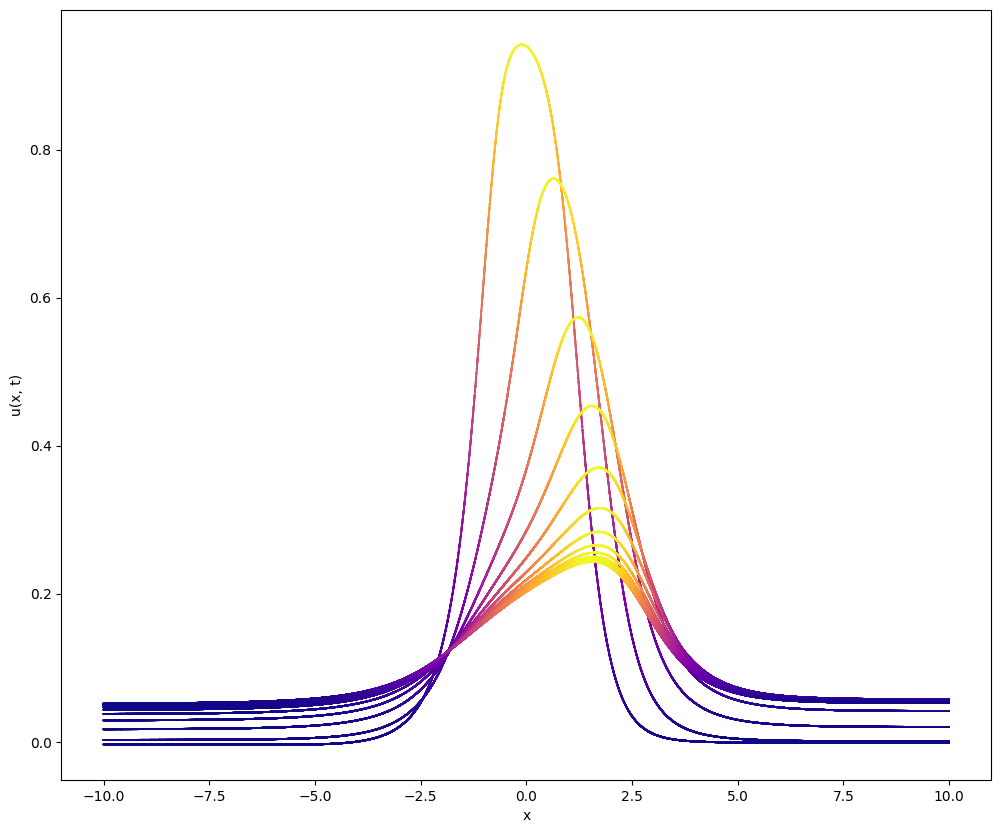

In [87]:
ax = plt.figure(figsize=(12, 10)).add_subplot()


for time_coef in torch.linspace(0, 20, 15):
    with torch.no_grad():
        u_sample = train_model.net(
            ModelInput(
                coords=Coords(x=x, y=None, z=None), 
                time=torch.ones(size=x.size()) * time_coef
            )
        ).logits

    ax.scatter(x, u_sample, s=0.1, alpha=0.9, c=u_sample, cmap="plasma")

ax.set_ylabel("u(x, t)")
ax.set_xlabel("x")

plt.show()

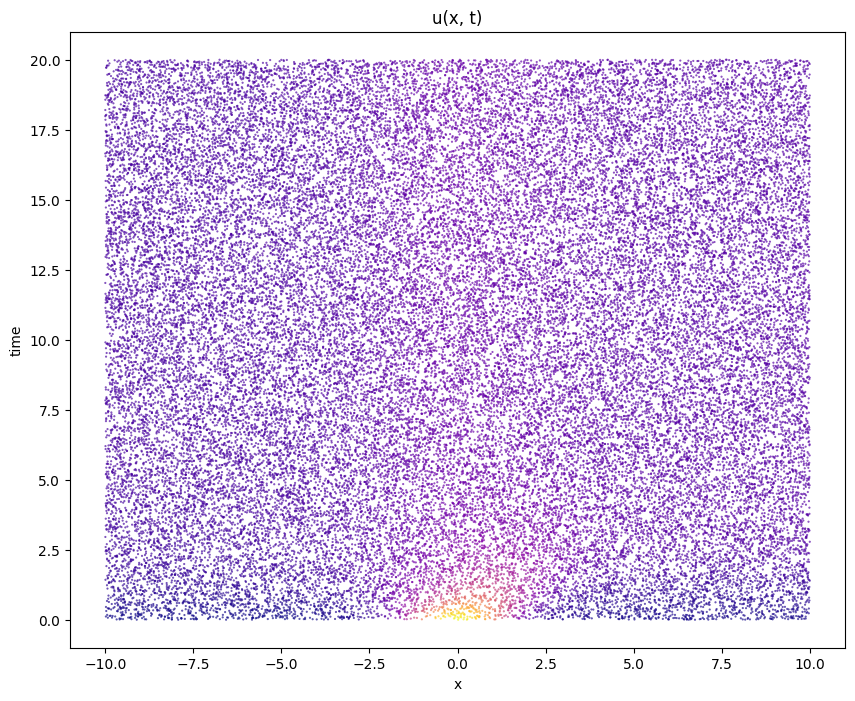

In [100]:
ax = plt.figure(figsize=(10, 8)).add_subplot()

ax.scatter(x, t, s=0.3, c=u, cmap="plasma", alpha=0.7)

ax.set_title("u(x, t)")
ax.set_ylabel("time")
ax.set_xlabel("x")

plt.show()

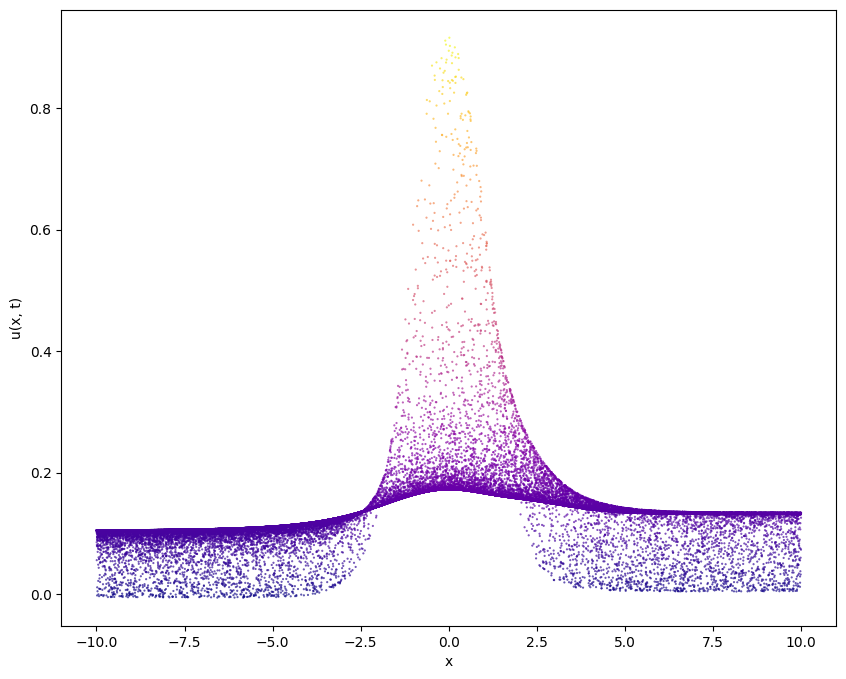

In [101]:
ax = plt.figure(figsize=(10, 8)).add_subplot()

ax.scatter(x, u, s=0.3, c=u, cmap="plasma", alpha=0.7)

ax.set_ylabel("u(x, t)")
ax.set_xlabel("x")

plt.show()

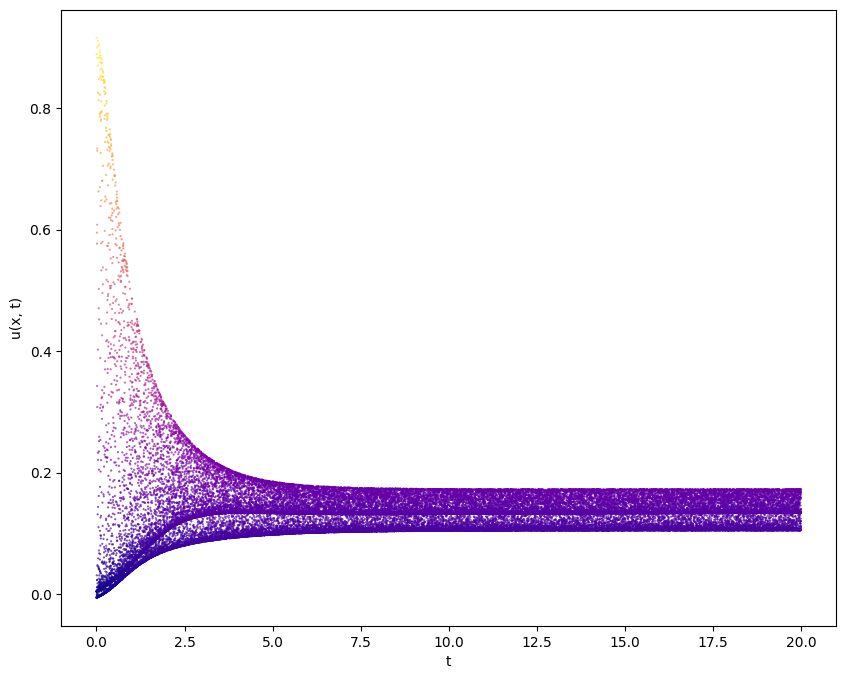

In [104]:
ax = plt.figure(figsize=(10, 8)).add_subplot()

ax.scatter(t, u, s=0.3, c=u, cmap="plasma", alpha=0.7)

ax.set_ylabel("u(x, t)")
ax.set_xlabel("t")

plt.show()

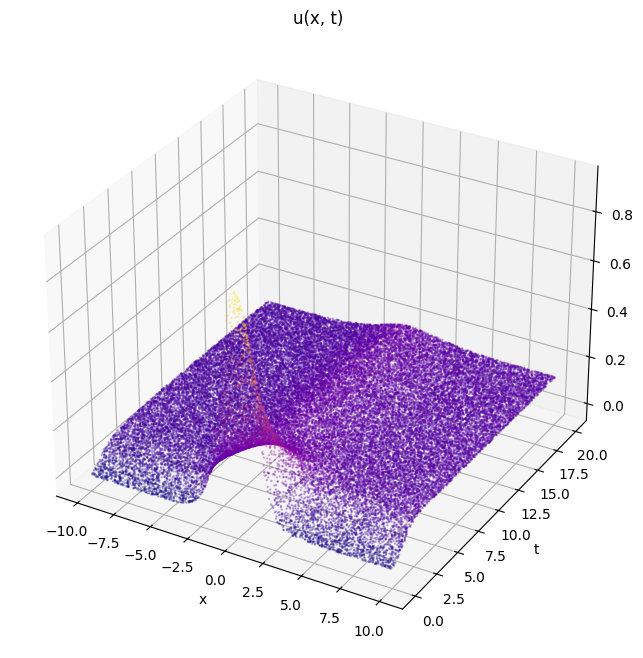

In [103]:
ax = plt.figure(figsize=(10, 8)).add_subplot(projection="3d")

ax.scatter(x, t, u, s=0.5, alpha=0.3, c=u, cmap="plasma")

ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title("u(x, t)")

plt.show()